Лабораторная работа #2. Реализовать мультимодальную векторизацию  с помощью tfidf, clip/blip, сохранить эмбеддинги для контента страниц из лабораторной работы #1 в файлы (в соответствующие папки).

# Предобработка

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
!pip install pymorphy2

In [119]:
import re
import string
import nltk
from nltk.corpus import stopwords
import pymorphy2

nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

morph = pymorphy2.MorphAnalyzer()

def preprocess_text(text):
    # Приведение текста к нижнему регистру
    text = text.lower()

    # Разделение текста на страницы
    pages = text.split('---page---')

    processed_pages = []
    for page in pages:
        # Удаление знаков препинания
        page = re.sub(r'[^\w\s]', '', page)
        page = re.sub(r'\d+', '', page)
        page = re.sub(r'\s+', ' ', page)

        words = page.split()
        words = [word for word in words if word not in stop_words]
        #words = list(set([morph.parse(word)[0].normal_form for word in words]))

        processed_page = ' '.join(words)

        processed_pages.append(processed_page)

    # Восстановление разделителя страниц
    processed_text = '\n---page---\n'.join(processed_pages)

    return processed_text

# Чтение контента из файла
path_local = '/Users/vlad-zharkov/Documents/Учеба/inf_search/‹ ¡  1/scraped_data_3/www_sports_ru/content_3.txt'
path_drive = '/content/drive/MyDrive/scraped_data_3/www_sports_ru/content_3.txt'


with open(path_drive, 'r', encoding='utf-8') as file:
    content = file.read()

# Предобработка текста
processed_content = preprocess_text(content)

# Сохранение предобработанного текста в файл (если нужно)
with open('processed_content_3.txt', 'w', encoding='utf-8') as file:
    file.write(processed_content)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Векторизация tf/idf

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Чтение предобработанного контента из файла
with open('processed_content_3.txt', 'r', encoding='utf-8') as file:
    processed_content = file.read()

# Разделение на документы (строки)
#documents = processed_content.split('\n')

# Инициализация TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(max_features=100)

# Применение TF-IDF векторизатора к документам
tfidf_embeddings = tfidf_vectorizer.fit_transform([processed_content]).toarray()

# Вывод размерности эмбеддингов
print("Shape of tfidf_embeddings:", tfidf_embeddings.shape)

Shape of tfidf_embeddings: (1, 100)


In [121]:
# Сохранение эмбеддингов в текстовый файл
np.savetxt('tfidf_embeddings.txt', tfidf_embeddings)

In [122]:
# Получение индексов слов в порядке убывания TF-IDF значений
feature_names = tfidf_vectorizer.get_feature_names_out()
sorted_indices = np.argsort(tfidf_embeddings[0])[::-1]

# Вывод слов и соответствующих им значений TF-IDF в порядке убывания значений
print(len(sorted_indices))
for index in sorted_indices:
    word = feature_names[index]
    tfidf_value = tfidf_embeddings[0][index]
    print(f"Слово: {word}, TF-IDF: {tfidf_value}")

100
Слово: сборная, TF-IDF: 0.3113869992307051
Слово: лига, TF-IDF: 0.22758173641906881
Слово: новости, TF-IDF: 0.21939682438771121
Слово: главная, TF-IDF: 0.2165655655089397
Слово: группа, TF-IDF: 0.20652746584784076
Слово: календарь, TF-IDF: 0.19582015954266857
Слово: ответить, TF-IDF: 0.18120056824137576
Слово: чемпионат, TF-IDF: 0.1810976133730568
Слово: игры, TF-IDF: 0.1754350956155138
Слово: матч, TF-IDF: 0.1743025920640052
Слово: время, TF-IDF: 0.17172872035603112
Слово: сколько, TF-IDF: 0.17039030706788458
Слово: кубок, TF-IDF: 0.1703388296337251
Слово: трибуна, TF-IDF: 0.164985176481139
Слово: смотреть, TF-IDF: 0.1571091290547383
Слово: начала, TF-IDF: 0.1559766255032297
Слово: россии, TF-IDF: 0.1511892241263979
Слово: вчера, TF-IDF: 0.1506229723506436
Слово: мая, TF-IDF: 0.14789466834019108
Слово: прямая, TF-IDF: 0.14470306742230318
Слово: трансляция, TF-IDF: 0.14470306742230318
Слово: футбол, TF-IDF: 0.1416658988068938
Слово: хоккей, TF-IDF: 0.11350774232165725
Слово: лч, TF

# Извлечение векторов признаков из изображений

# CLIP

In [123]:
# установим требуемые библиотеки
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-gynvi0yr
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-gynvi0yr
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [124]:
import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import os

In [125]:
import torch
print(torch.cuda.is_available())

False


In [126]:
# инициализируем модель и функцию для препроцессинга
model, preprocess = clip.load("ViT-B/32")
#model.cuda().eval()

In [127]:
# параметры модели
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [128]:
# загрузим изображения
image_folder = r'/content/drive/MyDrive/scraped_data_3/www_sports_ru'
image_paths = glob(os.path.join(image_folder, '*.jpg'))
image_paths.sort()

In [129]:
from PIL import UnidentifiedImageError

# подготовим изображения
original_images = []
images = []
count_err = 0
count = 0
count_excep = 0

for image_path in image_paths:
    try:
        image = Image.open(image_path).convert("RGB")
        original_images.append(image)
        images.append(preprocess(image))
    except UnidentifiedImageError:
        print(f"Cannot identify image file: {image_path}")
        os.remove(image_path)
        count_err += 1
    except Exception as e:
        print(f"Error processing file {image_path}: {e}")
        count_excep += 1

    count += 1

In [130]:
print(count, count_err, count_excep)

print(count_err/count)

4181 0 0
0.0


In [131]:
import os
import torch
import numpy as np
from glob import glob
from PIL import Image
from torchvision import transforms
from torchvision.models import vgg16

# Укажем разрешение
resolution = 224

# В качестве устройства будем использовать видеокарту, для этого укажем 'cuda:0'
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Трансформации для изображений для правильной подачи в нейронную сеть
transform = transforms.Compose([
    transforms.Resize((resolution, resolution)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Загружаем претрейн модели
model = vgg16(pretrained=True)

# Убираем классифицирующую голову
model = torch.nn.Sequential(*(list(model.children())[:-1]))

# Переносим модель на GPU/CPU
model = model.to(device)

# Переводим модель в режим "инференса"
model.eval()

# Определим функцию для эмбеддинга изображения
def get_feature(image_path, model, transform, device='cuda:0'):
    try:
        # Откроем изображение
        image = Image.open(image_path).convert('RGB')

        # Выполним трансформации, получим тензор
        image_tensor = transform(image)

        # Добавим дополнительную размерность в начале
        image_tensor = image_tensor.unsqueeze(0)  # 1, h, w, c

        # Перенесем наш тензор на GPU/CPU
        image_tensor = image_tensor.to(device)

        # Получим эмбеддинги в режиме no_grad - без вычислений градиентов
        with torch.no_grad():
            # Подаем тензор изображения в модель, получаем тензор-эмбеддинг на выходе
            embedding = model(image_tensor)

            # Переносим наш эмбеддинг на CPU
            embedding = embedding.cpu()

            # Вытягиваем эмбеддинг в плоский вектор и приводим к формату numpy
            embedding = embedding.flatten().numpy()

        # Возвращаем эмбеддинг
        return embedding
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Путь до папки с изображениями
image_folder = r'/content/drive/MyDrive/scraped_data_3/www_sports_ru'
image_paths = glob(os.path.join(image_folder, '*.jpg'))

# Список для хранения эмбеддингов
embeddings = []

# Получим эмбеддинги для всех изображений в папке
for image_path in image_paths:
    embedding = get_feature(image_path, model, transform, device=device)
    if embedding is not None:
        embeddings.append(embedding)

# Преобразуем список эмбеддингов в numpy массив
embeddings = np.array(embeddings)

# Вывод размерности эмбеддингов
print("Shape of embeddings:", embeddings.shape)

# Сохранение эмбеддингов в текстовый файл
np.savetxt('image_embeddings.txt', embeddings)

print("Embeddings saved to 'image_embeddings.txt'")

In [132]:
# подготовим тензор с батчем изображений для подачи в CLIP
image_input = torch.tensor(np.stack(images))

In [133]:
# подготовим текстовые запросы
queries = ["анчелотти",
           "пике",
           "реал"]

# токенизация текстовых запросов
query_tokens = clip.tokenize(queries)

In [134]:
# выберем случайным образом 8 изображений из датасета для визуализации
import random

#seed = 44
seed = 3112

image_folder = r'/content/drive/MyDrive/scraped_data_3/www_sports_ru'
image_paths = glob(os.path.join(image_folder, '*.jpg'))

random.seed(seed)
cur_image_paths = random.choices(image_paths, k=8)

In [135]:
# соберем списки с исходными изображениями и с их предобработанными версиями
original_images = []
images = []

for image_path in cur_image_paths:
  image = Image.open(image_path).convert("RGB")
  original_images.append(image)
  images.append(preprocess(image))

In [136]:
# подготовим тензор с батчем изображений для подачи в CLIP
image_input = torch.tensor(np.stack(images))

# прогоним через feature extractors и нормализуем
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

    text_features = model.encode_text(query_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [137]:
# получим матрицу вероятностей
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(3, dim=-1)

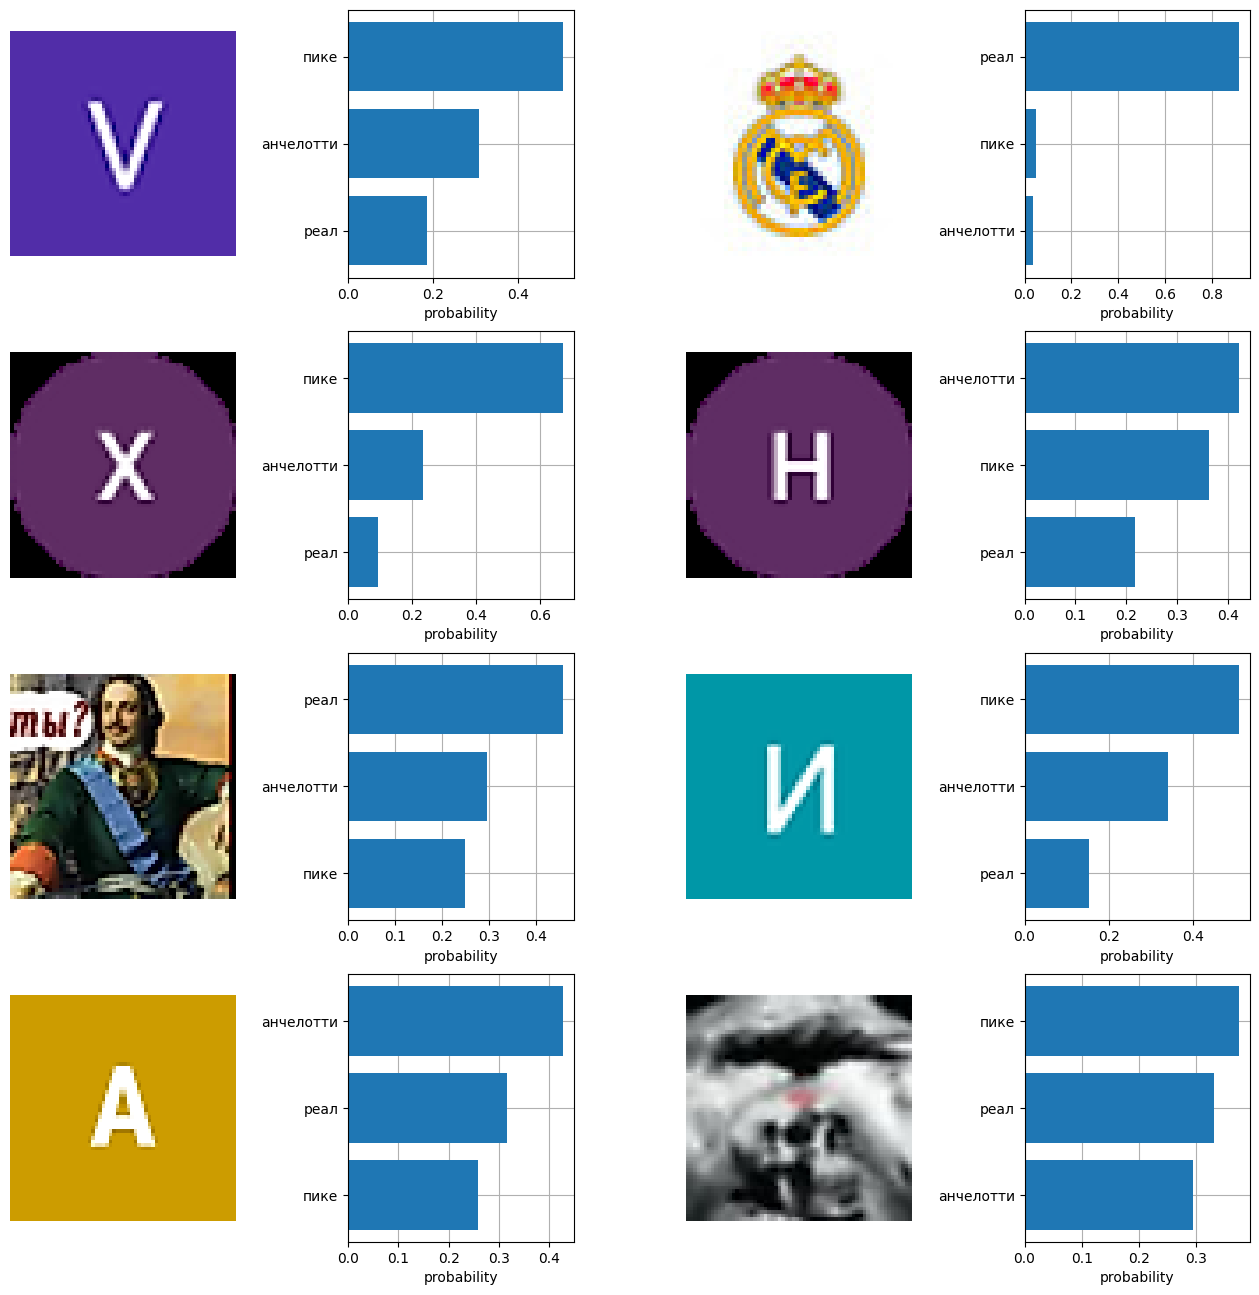

In [138]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [queries[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

# BLIP

In [139]:
#!pip install --user salesforce-lavis

In [140]:
import lavis
from lavis.models import load_model_and_preprocess
from lavis.models import model_zoo

print(model_zoo)

Architectures                  Types
albef_classification           ve
albef_feature_extractor        base
albef_nlvr                     nlvr
albef_pretrain                 base
albef_retrieval                coco, flickr
albef_vqa                      vqav2
alpro_qa                       msrvtt, msvd
alpro_retrieval                msrvtt, didemo
blip_caption                   base_coco, large_coco
blip_classification            base
blip_feature_extractor         base
blip_image_text_matching       base, large
blip_nlvr                      nlvr
blip_pretrain                  base
blip_retrieval                 coco, flickr
blip_vqa                       vqav2, okvqa, aokvqa
blip2_opt                      pretrain_opt2.7b, pretrain_opt6.7b, caption_coco_opt2.7b, caption_coco_opt6.7b
blip2_t5                       pretrain_flant5xl, pretrain_flant5xl_vitL, pretrain_flant5xxl, caption_coco_flant5xl
blip2_feature_extractor        pretrain, pretrain_vitL, coco
blip2                      

In [141]:
device = "cuda:0"
model, vis_processors, _ = load_model_and_preprocess(name="blip_caption", model_type="base_coco", is_eval=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [142]:
from glob import glob

image_folder = r'/content/drive/MyDrive/scraped_data_3/www_sports_ru'
image_paths = glob(os.path.join(image_folder, '*.jpg'))

In [143]:
captions = []
for image_path in image_paths[:6]:
  img = Image.open(image_path).convert('RGB')
  img = vis_processors["eval"](img).unsqueeze(0)
  captions.append(model.generate({"image": img})[0])

In [144]:
import cv2

def plot_images(y_paths, y_titles):
  fig = plt.figure(figsize=(15,15), dpi=100)
  rows, cols = 3, 2

  for i, path in enumerate(y_paths[:rows*cols]):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = cv2.resize(img, (224, 224))

    fig.add_subplot(rows, cols, i+1)
    plt.title(y_titles[i])
    plt.imshow(img)
    plt.axis('off')

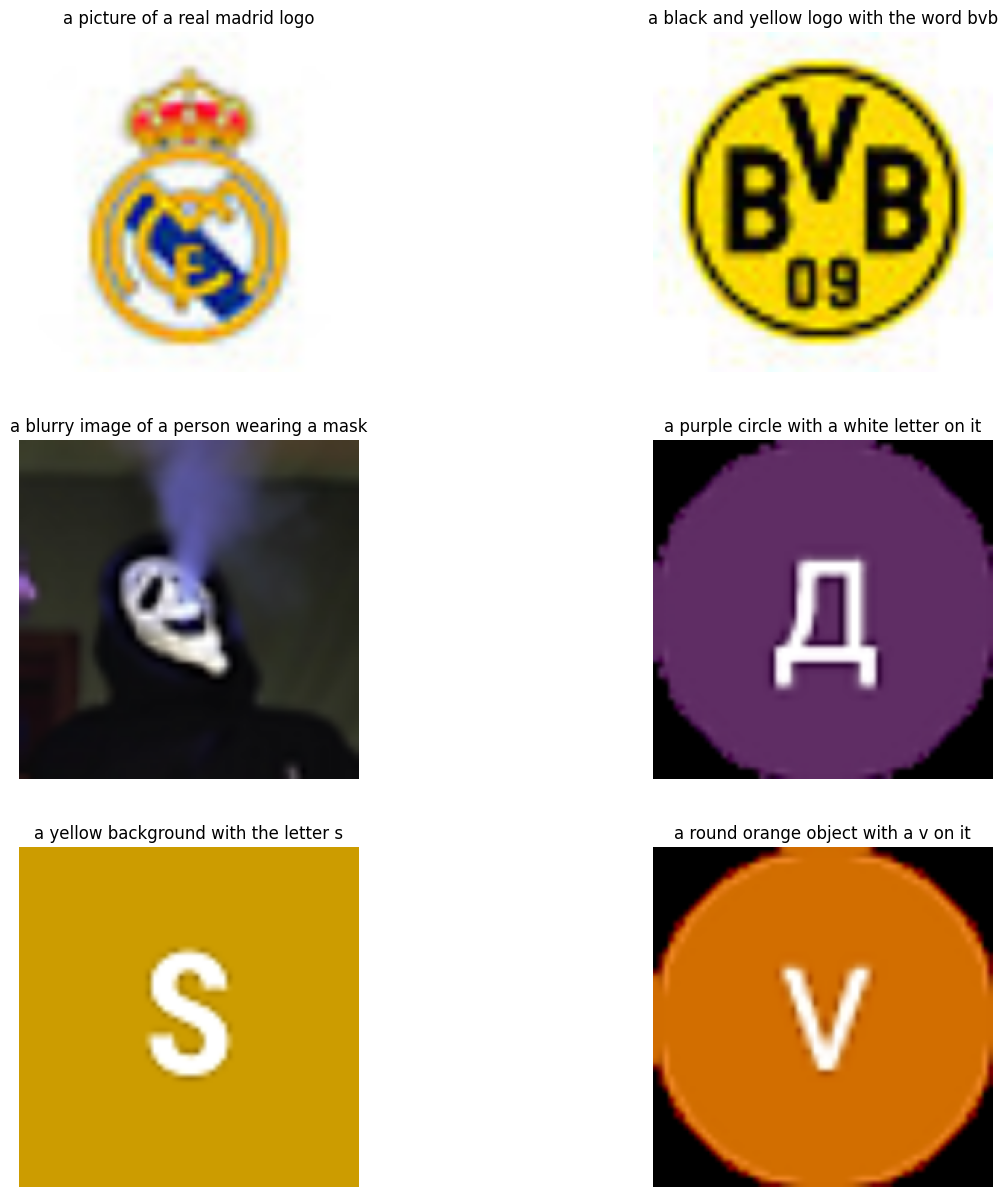

In [145]:
plot_images(image_paths[:6], captions)